In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory 
data_dir = ""

# directory where the simulation data and table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
output_dir = "../../data/clonal_count_estimation/"

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
clonal_calls = pd.read_csv(output_dir+"clonal_SNVs_WES_WGS.csv", index_col=0)
WGS_maf = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
WES_maf = pd.read_csv(data_dir+"HTAN_WES_filtered_ppVAFs.maf", sep="\t")

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def get_SNVs_only(maf):
    return maf[maf["Variant_Type"]=="SNP"]

SNVs_only_WGS = get_SNVs_only(WGS_maf)
SNVs_only_WES = get_SNVs_only(WES_maf)
sample_to_stage = dict(zip(WGS_maf["Tumor_Sample_Barcode"], WGS_maf["Stage"]))
sample_to_stage.update(dict(zip(WES_maf["Tumor_Sample_Barcode"], WES_maf["Stage"])))

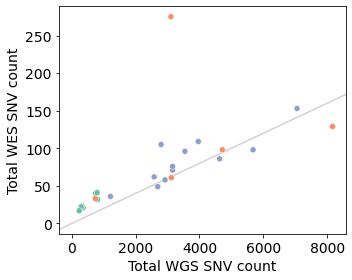

In [5]:
# EXTENDED DATA FIGURE 6a

has_both = clonal_calls[np.logical_and(clonal_calls["has_WGS"], clonal_calls["has_WES"])].index.tolist()

total_WES = []
total_WGS = []
for sample in has_both:
    total_WES.append(len(SNVs_only_WES[SNVs_only_WES["Tumor_Sample_Barcode"]==sample]))
    total_WGS.append(len(SNVs_only_WGS[SNVs_only_WGS["Tumor_Sample_Barcode"]==sample]))
    
to_plot = pd.DataFrame({"total_WES":total_WES, "total_WGS":total_WGS}, index=has_both)
to_plot["stage"] = [sample_to_stage[x] for x in to_plot.index]

fig,ax = plt.subplots(1, 1, figsize=(5,4))
sns.scatterplot(x=to_plot["total_WGS"], y=to_plot["total_WES"], hue=to_plot["stage"], hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", legend=None, ax=ax)
plt.axline([0,0], [np.max(to_plot["total_WGS"]), 0.02*np.max(to_plot["total_WGS"])], color="lightgrey", zorder=-10)
plt.xlabel("Total WGS SNV count", fontsize=14)
plt.ylabel("Total WES SNV count", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(ticks=[0,2000,4000,6000,8000], labels=[0,2000,4000,6000,8000], fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED7a_ourWES_total_WESWGS_compare.pdf")

plt.show()

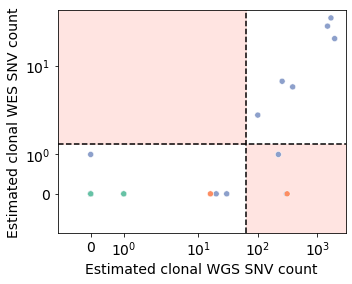

In [6]:
# EXTENDED DATA FIGURE 6b

to_plot = clonal_calls[np.logical_and(clonal_calls["has_WGS"], clonal_calls["has_WES"])]

WGS_cutoff = (27 + 36)
WES_cutoff = WGS_cutoff * 0.02

fig,ax = plt.subplots(1, 1, figsize=(5,4))
sns.scatterplot(x=to_plot["final_clonal_WGS"], y=to_plot["final_clonal_WES"], hue=to_plot["stage"], hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", legend=None, ax=ax)
ax.axhline(y=WES_cutoff, color="k", linestyle="dashed")
ax.axvline(x=WGS_cutoff, color="k", linestyle="dashed")
plt.fill_between(x=[WGS_cutoff, 3e3], y1=[WES_cutoff, WES_cutoff], y2=[-1, -1], where=[True, True], step="post", color="mistyrose", zorder=-100)
plt.fill_betweenx(y=[WES_cutoff, 60], x1=[WGS_cutoff, WGS_cutoff], x2=[-1, -1], where=[True, True], step="post", color="mistyrose", zorder=-100)

plt.xlim(-1, 3e3)
plt.ylim(-1, 60)
plt.yscale("symlog")
plt.xscale('symlog')
plt.xlabel("Estimated clonal WGS SNV count", fontsize=14)
plt.ylabel("Estimated clonal WES SNV count", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED7b_ourWES_clonal_WESWGS_compare.pdf")
plt.show()

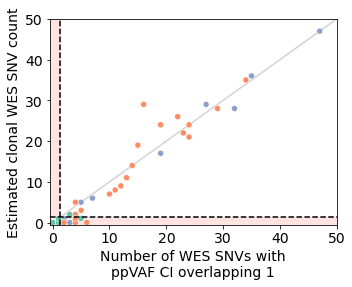

In [7]:
# EXTENDED DATA FIGURE 6c

WES_maf["upper_CI_clonal"] = WES_maf["ppVAF_upper"] == 1
only_upper_CI = WES_maf[["upper_CI_clonal", "Tumor_Sample_Barcode"]].groupby("Tumor_Sample_Barcode").sum()

to_plot = clonal_calls[clonal_calls["has_WES"]].join(only_upper_CI)

fig,ax = plt.subplots(1, 1, figsize=(5,4))
sns.scatterplot(x=to_plot["upper_CI_clonal"], y=to_plot["final_clonal_WES"], hue=to_plot["stage"], hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", legend=None, ax=ax)
plt.axline([0,0], [11, 11], zorder=-99, color="lightgrey")
ax.axhline(y=WES_cutoff, color="k", linestyle="dashed")
ax.axvline(x=WES_cutoff, color="k", linestyle="dashed")
plt.fill_between(x=[WES_cutoff, 50], y1=[WES_cutoff, WES_cutoff], y2=[-1, -1], where=[True, True], step="post", color="mistyrose", zorder=-100)
plt.fill_betweenx(y=[WES_cutoff, 50], x1=[WES_cutoff, WES_cutoff], x2=[-1, -1], where=[True, True], step="post", color="mistyrose", zorder=-100)

plt.xlabel("Number of WES SNVs with\nppVAF CI overlapping 1", fontsize=14)
plt.ylabel("Estimated clonal WES SNV count", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(-0.5, 50)
plt.ylim(-0.5, 50)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED7c_ourWES_clonalSNV_compare.pdf")
plt.show()

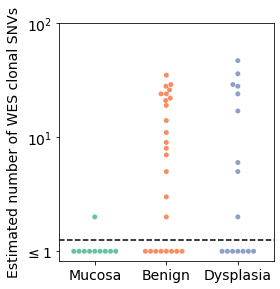

In [8]:
# EXTENDED DATA FIGURE 6d
to_plot = clonal_calls[clonal_calls["has_WES"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.swarmplot(x=to_plot["stage"], y=np.log10(np.maximum(to_plot["final_clonal_WES"], 1)), hue=to_plot["stage"], order=["Mucosa", "Benign", "Dysplasia"], hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", ax=axs, legend=None)
#axs.set_yscale("log")
plt.xlabel("", fontsize=14)
plt.ylabel("Estimated number of WES clonal SNVs", fontsize=14) 
axs.axhline(y=np.log10(WES_cutoff), color="k", linestyle="dashed")
plt.yticks(ticks = [0, 1, 2], labels = ["$\leq 1$", "$10^{1}$", "$10^{2}$"], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED7d_ourWES_clonal_bystage_strip.pdf")
plt.show()

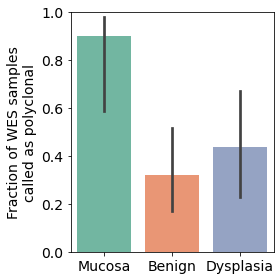

In [9]:
# EXTENDED DATA FIGURE 6e

def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data), np.sum(~binom_data))

only_WES_clonal = clonal_calls[clonal_calls["has_WES"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.barplot(x=only_WES_clonal["stage"], y=only_WES_clonal["is_poly_WES"].astype("boolean"), order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
plt.ylabel("Fraction of WES samples\ncalled as polyclonal", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED7e_ourWES_clonal_bystage_bar.pdf")
plt.show()